# <font color = Crimson size = 6> <b>Дисперсионный анализ</b> </font>

In [1]:
import numpy as np
import pandas as pd

import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

import matplotlib.pyplot as plt
import seaborn as sns

***
## <font color = DarkGreen size = 5> <b>Однофакторный дисперсионный анализ (ANOVA)</b> </font>

Очень часто в экспериментах и исследованиях возникает необходимость сравнить несколько групп между собой. В таком случае мы можем применять однофакторный дисперсионный анализ.  Та переменная, которая будет разделять наших испытуемых или наблюдения на группы (номинативная переменная с нескольким градациями) называется **независимой переменной** $x$. А та количественная переменная, по степени выраженности которой мы сравниваем группы, называется **зависимая переменная** $y$.

В однофакторном дисперсионном анализе на одну количественную переменную $y$ влияет один фактор, который наблюдается на $k$ уровнях или имеет $k$ выборок (групп) для переменной $y$.

Можем посчитаем средние по каждой выборке и сравним их средние между собой. И если мы обнаружим статистически значимые различия хотя бы между одной парой, то приходим к выводу, что есть статистически значимый эффект.

Появляется эффект **множественных сравнений** - с увеличением числа сравнений $m$ растет вероятность ошибки 1 рода, т.е. растет вероятность найти различия там, где их нет (растет вероятность принять гипотезу $H_1$, когда на самом деле верна гипотеза $H_0$). И вместо привычного, заранее выбранного уровня статистической значимости $\alpha$, появляется $\bar{\alpha}$, которая является истинным уровнем значимости многократно примененного критерия: \
$\bar{\alpha} = 1 - (1 - \alpha)^m$, где $m = С_k^2$ - кол-во парных сравнений.

Чтобы этого избежать, лучше использовать **дисперсионный анализ**:
1. Формулируем нулевую и альтернативную гипотезы. \
Нулевая гипотеза будет предполагать, что на самом деле все группы принадлежат одной генеральной совокупности и соотвественно имеют одно математическое ожидание. \
Альтернативная гипотеза говорит о том, что хотя бы две выборки статически значимо различаются, то есть хотя бы две средних отличаются друг от друга.
<br><br>

2. Устанавливаем уровень статистической значимости $\alpha$.
<br><br>

3. В дисперсионном анализе используется критерий Фишера. \
Табличное значение определяется на основе общего чила наблюдений в группах $n$, степеней свободы и заданного уровня значимости следующим образом: \
$F_к(\alpha,k_1,k_2)$, где \
$k_1 = k-1$ \
$k_2 = n-k$
<br><br>

F-критерий Фишера рассчитывается по следующей формуле:\
$F = \cfrac{MSB}{MSW}$, где \
$MSB = \cfrac{SSB^2}{k-1}$ - межгрупповой средний квадрат / межгрупповая дисперсия / факторная дисперсия, \
$MSW = \cfrac{SSW^2}{n-k}$ - внутригрупповой средний квадрат / внутригрупповая дисперсия / остаточная дисперсия.
<br><br>

$SS$ (sum of squares) - **сумма квадратов** (отклонения от какого-либо среднего значения):

$\displaystyle SST = \sum_{i=1}^{k} \sum_{j=1}^{n_i} {(x_{ij} - \bar{X})^2}$ - общее число квадратов отклонений (Total Sum Of Squares)

$\displaystyle SSB = \sum_{i=1}^{k}{(\bar{x_i} - \bar{X})^2 \cdot n_i}$ - факторная сумма квадратов отклонений средних групповых значений от общего среднего (Between Groups Sums of Squares)

$\displaystyle SSW = \sum_{i=1}^{k} \sum_{j=1}^{n_i} {(x_{ij} - \bar{x_i})^2}$ - остаточная сумма квадратов отклонений значений от группового среднего (Within Groups Sums of Squares)

$k$ - количество групп, $n_i$ - число наблюдений в $i$-ой группе.
    
$SST = SSB + SSW$
<br><br>

4. Выводы: если $F_н < F_к$, то принимаем $H_0$.
<img src="./img/st_09_image1.png" alt="st_13_image1" width=""/>

In [2]:
def ssb(data: pd.DataFrame, X: str, Y: str):
    group_names = data[X].unique()
    My = data[Y].mean()
    return np.sum([
        len(data.loc[data[X] == group, Y]) * 
        (data.loc[data[X] == group, Y].mean() - My) ** 2
        for group in group_names
    ])

In [3]:
def ssw(data: pd.DataFrame, X: str, Y: str):
    group_names = data[X].unique()
    return np.sum([
        (data.loc[data[X] == group, Y] - data.loc[data[X] == group, Y].mean()) ** 2
        for group in group_names
    ])

##### <font color = SlateBlue size = 3> Пример </font>

Генотерапия позволяет корректировать работу дефективного гена, ответственного за развитие заболевания. В эксперименте сравнивалась эффективность четырех различных типов терапии.

In [4]:
df = pd.read_csv('.\data\genetherapy.csv')

In [5]:
df.groupby('Therapy').agg({'expr': ['count', 'mean', 'std']})

expr                     
        count       mean       std
Therapy                           
A          15  99.733333  4.165619
B          15  98.800000  5.894307
C          15  94.400000  5.193402
D          15  92.333333  3.735289

In [6]:
groups = df['Therapy'].unique()
subsets = [df.query('Therapy == @group')['expr'] for group in groups]

ssb_df = len(groups) - 1
ssw_df = df.shape[0] - len(groups)

SSW = ssw(df, 'Therapy', 'expr')
SSB = ssb(df, 'Therapy', 'expr')

Fk, p_value = stats.f_oneway(*subsets)

In [7]:
anova_results = pd.DataFrame([
{
        'Df': ssb_df, # число степеней свободы
        'Sum Sq': '{0:.2f}'.format(SSB), # межгрупповая сумма квадратов
        'Mean Sq': '{0:.2f}'.format(SSB / ssb_df), # межгрупповая изменчивость
        'F-value': '{0:.2f}'.format(Fk), # F-критерий Фишера
        'p-value': '{0:.4f}'.format(p_value),
    },
    {
        'Df': ssw_df,
        'Sum Sq': '{0:.2f}'.format(SSW), # внутригрупповая сумма квадратов
        'Mean Sq': '{0:.2f}'.format(SSW / ssw_df), # внутригрупповая изменчивость
        'F-value': '',
        'p-value': '',
    },
], index=['Therapy', 'Residuals'])

anova_results

,Df,Sum Sq,Mean Sq,F-value,p-value
Therapy,3,560.72,186.91,8.04,0.0002
Residuals,56,1302.27,23.25,,


In [8]:
rehab_lm = ols('expr ~ Therapy', data=df).fit()
sm.stats.anova_lm(rehab_lm)

,df,sum_sq,mean_sq,F,PR(>F)
Therapy,3.0,560.716667,186.905556,8.037302,0.000152
Residual,56.0,1302.266667,23.254762,NaN,NaN


$p-value < 0.05$, что позволяет нам отклонить $H_0$.

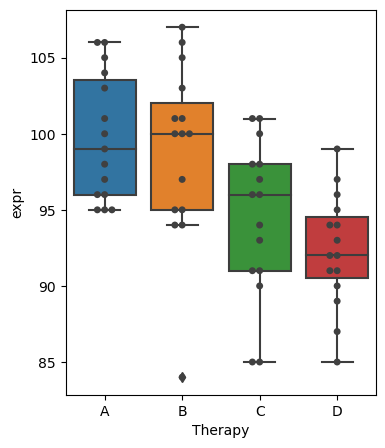

In [9]:
plt.figure(figsize=(4, 5))
sns.boxplot(data=df, x='Therapy', y='expr')
sns.swarmplot(data=df, x='Therapy', y='expr', color='.25');

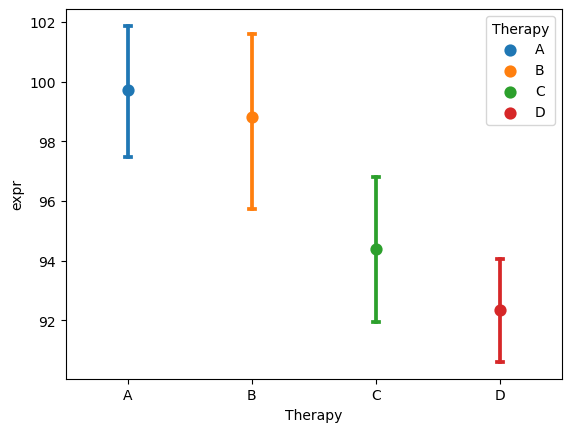

In [10]:
# доверительные интервалы 95%
sns.pointplot(data=df, x='Therapy', y='expr', hue='Therapy', ci=95, join=False, capsize=.05);

***
## <font color = DarkGreen size = 5> <b>Множественные сравнения в ANOVA</b> </font>

***
### <font color = MediumBlue size = 4> <b>Поправка Бонферрони</b> </font>

Статистическая проверка гипотез основана на отклонении нулевой гипотезы, если вероятность того, что наблюдаемые данные соответствуют нулевой гипотезе, невелика. Если проверяется несколько гипотез, вероятность наблюдения редкого события возрастает, и, следовательно, увеличивается вероятность неправильного отклонения нулевой гипотезы (т.е. совершения ошибки I рода).

Поправка Бонферрони компенсирует это увеличение путем проверки каждой отдельной гипотезы на уровне значимости \
$\bar{\alpha} = \cfrac{\alpha}{m}$, где $\alpha$ - желаемый уровень значимости, $m = С_k^2$ - кол-во парных сравнений.

***
### <font color = MediumBlue size = 4> <b>Критерий Тьюки</b> </font>

Критерий Тьюки используется для проверки нулевой гипотезы $H_0: \mu_A = \mu_B$ против альтернативной гипотезы $H_1: \mu_A \not= \mu_B$, где индексы $A$ и $B$ обозначают любые две сравниваемые группы. При наличии $m$ групп всего возможно выполнить $\cfrac{m(m-1)}{2}$ попарных сравнений.

Первый шаг заключается в упорядочивании всех имеющихся групповых средних значений по возрастанию (от 1 до $m$). Далее выполняют попарные сравнения этих средних так, что сначала сравнивают наибольшее среднее с наименьшим, т.е. $m$-ое с 1-ым, затем $m$-ое со 2-ым, 3-м, и т.д. вплоть до $(m−1)$-го. Затем предпоследнее среднее, $(m−1)$-ое, тем же образом сравнивают с 1-ым, 2-ым, и т.д. до $(m−2)$-го. Эти сравнения продолжаются до тех пор, пока не будут перебраны все пары.

Указанные сравнения выполняются при помощи критерия Тьюки, который представляет собой модифицированный критерий Стьюдента: \
$q = \cfrac{\bar{x}_B - \bar{x}_A}{SE}$

Отличие от критерия Стьюдента заключается в том, как рассчитывается стандартная ошибка $SE$: \
$SE = \sqrt{\cfrac{MSW}{n}}$, где \
$MSW$ - рассчитываемая в ходе дисперсионного анализа внутригрупповая дисперсия.

Приведенная формула для критерия Тьюки верна для случаев, когда все сравниваемые группы содержат одинаковое число наблюдений $n$. Если сравниваемые группы неодинаковы по размеру, стандартная ошибка будет рассчитываться следующим образом: \
$SE = \sqrt{\cfrac{MSW}{2} \left(\cfrac{1}{n_A}+\cfrac{1}{n_B}\right)}$

Благодаря тому обстоятельству, что в приведенные выше формулы стандартной ошибки входит внутригрупповая дисперсия $MSW$, обеспечивается контроль над групповой вероятностью ошибки первого рода. Именно это делает критерий Тьюки подходящим критерием для выполнения большого числа попарных сравнений групповых средних.

In [11]:
tukey = pairwise_tukeyhsd(endog=df['expr'], groups=df['Therapy'], alpha=0.05)
print(tukey)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     A      B  -0.9333 0.9514  -5.5959  3.7292  False
     A      C  -5.3333 0.0189  -9.9959 -0.6708   True
     A      D     -7.4 0.0005 -12.0626 -2.7374   True
     B      C     -4.4  0.071  -9.0626  0.2626  False
     B      D  -6.4667 0.0029 -11.1292 -1.8041   True
     C      D  -2.0667 0.6458  -6.7292  2.5959  False
-----------------------------------------------------


meandiff - разность средних \
p-adj - p-value \
lower - нижняя граница доверительного интервала \
upper - верхняя граница доверительного интервала

Хотя теория того не требует, критерий Тьюки и другие подобные ему методы рекомендуется применять после того, как дисперсионный анализ установил наличие существенной разницы между группами в целом. В связи с этим критерий Тьюки относится к методам апостериорного анализа (post-hoc analysis).

Критерий Тьюки имеет те же условия применимости, что и собственно дисперсионный анализ, т.е. нормальность распределения данных и (особенно важно!) однородность групповых дисперсий. Устойчивость к отклонению от этих условий, равно как и статистическая мощность критерия Тьюки, возрастают при одинаковом числе наблюдений во всех сравниваемых группах.

***
## <font color = DarkGreen size = 5> <b>Многофакторный дисперсионный анализ</b> </font>

***
### <font color = MediumBlue size = 4> <b>Двухфакторный дисперсионный анализ</b> </font>

В двухфакторном дисперсионном анализе на одну количественную переменную $Y$ влияют два фактора (два качественных показателя), наблюдаемых соответственно на $k$ и $m$ уровнях.

Общая сумма квадратов отклонений $SST$ равна: \
$SST = SSW + SSB_A + SSB_B + SSB_{AB}$, где \
$SSW$ - остаточная сумма квадратов отклонений значений от группового среднего (внутригрупповая) \
$SSB_A$ - сумма квадратов отклонений фактора $A$, \
$SSB_B$ - сумма квадратов отклонений фактора $B$, \
$SSB_{AB}$ - сумма квадратов отклонений взаимодействия факторов $A$ и $B$.

##### <font color = SlateBlue size = 3> Пример </font>

Атеросклероз - причина ишемической болезни сердца и инсультов. Анализ экспрессии генов лейкоцитов позволяет предсказать вероятность развития данного заболевания. В эксперименте исследовался уровень экспрессии в зависимости от возраста пациентов и дозировки лекарства аторвастатина.

In [12]:
df = pd.read_csv(r'.\data\atherosclerosis.csv')

In [13]:
df.groupby(['age', 'dose']).agg({'expr': ['count', 'mean', 'std']})

expr                      
         count        mean       std
age dose                            
1   D1      16  104.758464  5.863454
    D2      16  105.545864  4.369024
2   D1      16  101.004805  5.116310
    D2      16  102.273629  5.135374

In [14]:
rehab_lm = ols('expr ~ age * dose', data=df).fit()
sm.stats.anova_lm(rehab_lm)

,df,sum_sq,mean_sq,F,PR(>F)
dose,1.0,16.912241,16.912241,0.638094,0.427552
age,1.0,197.452754,197.452754,7.449841,0.008313
age:dose,1.0,0.927077,0.927077,0.034978,0.852272
Residual,60.0,1590.257424,26.504290,NaN,NaN


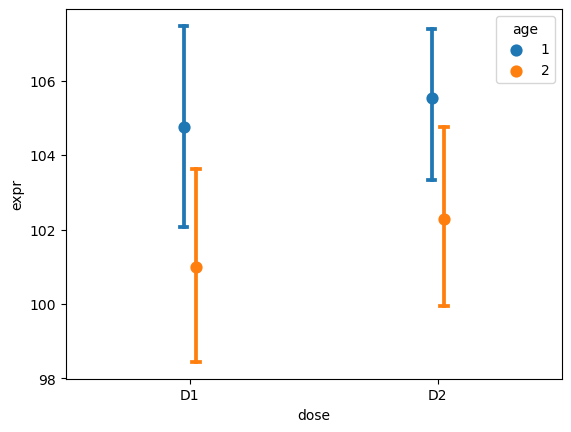

In [15]:
sns.pointplot(data=df, x='dose', y='expr', hue='age', join=False, dodge=True, capsize=0.03);

##### <font color = SlateBlue size = 3> Пример </font>

Исследователей интересовало влияние инъекции некоторго гормона на показатель концентрации кальция в плазме крови у птиц с учетом их пола.

In [16]:
df = pd.read_csv(r'.\data\birds.csv')

In [17]:
df.groupby(['hormone', 'sex']).agg({'var4': ['count', 'mean', 'std']})

var4                     
            count       mean       std
hormone sex                           
0       0      16  19.887291  3.677211
        1      16  17.608916  2.449753
1       0      16  17.292254  2.864428
        1      16  19.743662  3.383574

In [18]:
lm = ols('var4 ~ hormone * sex', data=df).fit()
sm.stats.anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
hormone,1.0,0.847472,0.847472,0.086528,0.769653
sex,1.0,0.119762,0.119762,0.012228,0.912318
hormone:sex,1.0,89.483384,89.483384,9.136390,0.003682
Residual,60.0,587.650394,9.794173,NaN,NaN


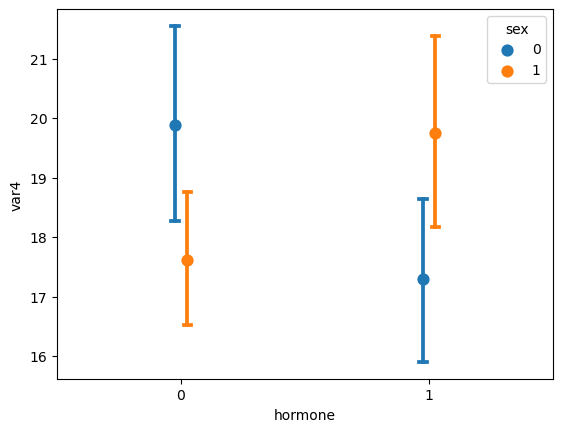

In [19]:
sns.pointplot(data=df, x='hormone', y='var4', hue='sex', join=False, dodge=True, capsize=0.03);

***
## <font color = DarkGreen size = 5> <b>Условия применимости дисперсионного анализа</b> </font>

1. Значения групп должны следовать нормальному распределению.
2. Однородность/гомогенность дисперсий

> При достаточно большом количестве наблюдений ($>50$) ANOVA устойчив к нарушению обоих этих ограничений.


In [20]:
df['group'] = 'A'
df.loc[(df['hormone']==0) & (df['sex']==1), 'group'] = 'B'
df.loc[(df['hormone']==1) & (df['sex']==0), 'group'] = 'C'
df.loc[(df['hormone']==1) & (df['sex']==1), 'group'] = 'D'

In [21]:
for g in ('A','B','C','D'):
    print(g, end=': ')    
    print(stats.shapiro(df[df['group']==g]['var4']))

A: ShapiroResult(statistic=0.94510418176651, pvalue=0.4162890613079071)
B: ShapiroResult(statistic=0.9067473411560059, pvalue=0.10314302891492844)
C: ShapiroResult(statistic=0.9721516370773315, pvalue=0.8721426129341125)
D: ShapiroResult(statistic=0.94819176197052, pvalue=0.4615950882434845)


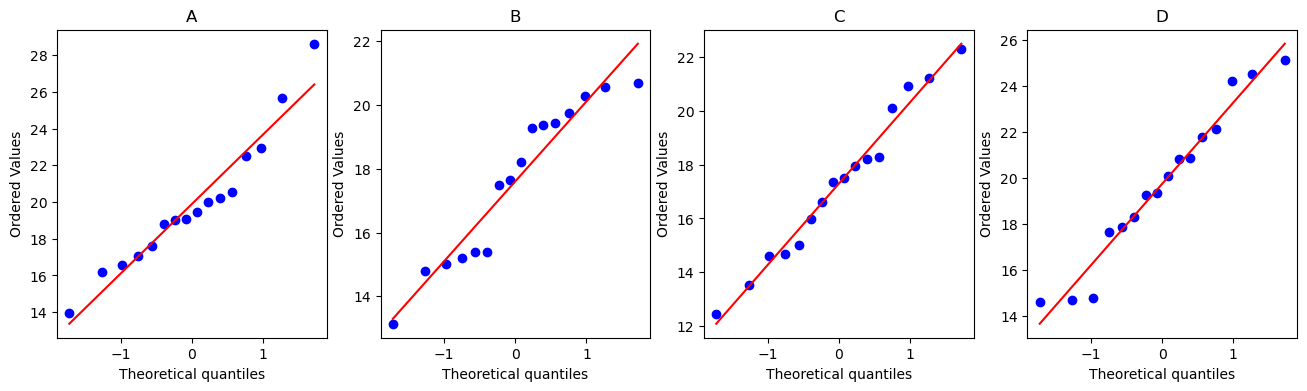

In [22]:
plt.figure(figsize = [4*4, 4])

for i,g in enumerate(('A','B','C','D'), 1):
    plt.subplot(1, 4, i)
    stats.probplot(df[df['group']==g]['var4'], dist="norm", plot=plt)
    plt.title(f'{g}')

In [23]:
# проверка на однородность дисперсий
stats.bartlett(df[df['group']=='A']['var4'], 
               df[df['group']=='B']['var4'], 
               df[df['group']=='C']['var4'],
               df[df['group']=='D']['var4'])

BartlettResult(statistic=2.7476457988544323, pvalue=0.43219101862812426)